# Outlier Detection and Prediction on Wheel Speed Sensor

## Summary
This notebook gives summerize of the findings of this project so far and illustrates next steps

## Questions to be answered
- What is the statistics per feature at the sensor and trailer level?
- Do the sensors in a same trailer behave the same?
- What kind of methods are used in outlier detection?
- How does the average pick-up speed change over time?
- How does the NA value ratio change over time?

### Imports
Imports should be grouped in the following order:
1. Magics

2. Alphabetical order
    
    A. standard librarby imports
    
    B. related 3rd party imports
    
    C. local application/library specific imports

In [1]:
# Magics
%matplotlib inline
# Do below if you want interactive matplotlib plot ()
# %matplotlib notebook

# Reload modules before executing user code
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Show version information for dependency modules
# https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas

Software versions
Python 3.5.2 64bit [MSC v.1900 64 bit (AMD64)]
IPython 5.1.0
OS Windows 7 6.1.7601 SP1
numpy 1.11.1
scipy 0.18.1
matplotlib 1.5.3
pandas 0.18.1
Fri Dec 09 12:30:11 2016 W. Europe Standard Time

In [2]:
# Standard library
import os
import sys
# sys.path.append('../src/')

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import rpy2.robjects as robjects
import statistics as stats
import scipy.stats as ss
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.font_manager
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler

# Local imports

In [3]:
# Customizations
sns.set() # matplotlib defaults

# Any tweaks that normally go in .matplotlibrc, etc., should be explicitly stated here
plt.rcParams['figure.figsize'] = (12,8)
%config InlineBackend.figure_format = 'retina'

In [3]:
# Find  the notebook the saved figures came from
fig_prefix = '../figures/2016-12-07-rm-'

## Descriptive Statistics
### Sensor Level

In [7]:
df = pd.read_pickle('../data/wss_n_c1')
m = pd.read_pickle('../data/manufacturer')

In [8]:
df = pd.merge(df, m, how='left', on='itapudid')
df = df[df['ebs_mfg'] == 'Knorr Bremse']

In [9]:
df.head(5)

,itapudid,speed,eventtime,sensor,ebs_mfg
0,163540031001DC924C7B3,0.0,1970-01-01,C,Knorr Bremse
1,163540031001DC924C7B3,0.0,1970-01-01,D,Knorr Bremse
2,163540032001DC9248262,0.0,1970-01-01,E,Knorr Bremse
3,163540032001DC9248262,0.0,1970-01-01,F,Knorr Bremse
10,164750012001DC915CCBF,0.0,1970-01-01,C,Knorr Bremse


In [10]:
# Divide the dataset into 4 parts, and describe them per sensor
df1 = df[df.sensor == 'C']
df2 = df[df.sensor == 'D']
df3 = df[df.sensor == 'E']
df4 = df[df.sensor == 'F']

In [7]:
df1.describe()

,speed
count,106904.000000
mean,8.911322
std,11.700352
min,0.000000
25%,1.000000
50%,3.000000
75%,14.000000
max,126.000000


In [8]:
df3.describe()

,speed
count,1858.000000
mean,6.257804
std,8.804510
min,0.000000
25%,2.000000
50%,3.000000
75%,7.000000
max,79.000000


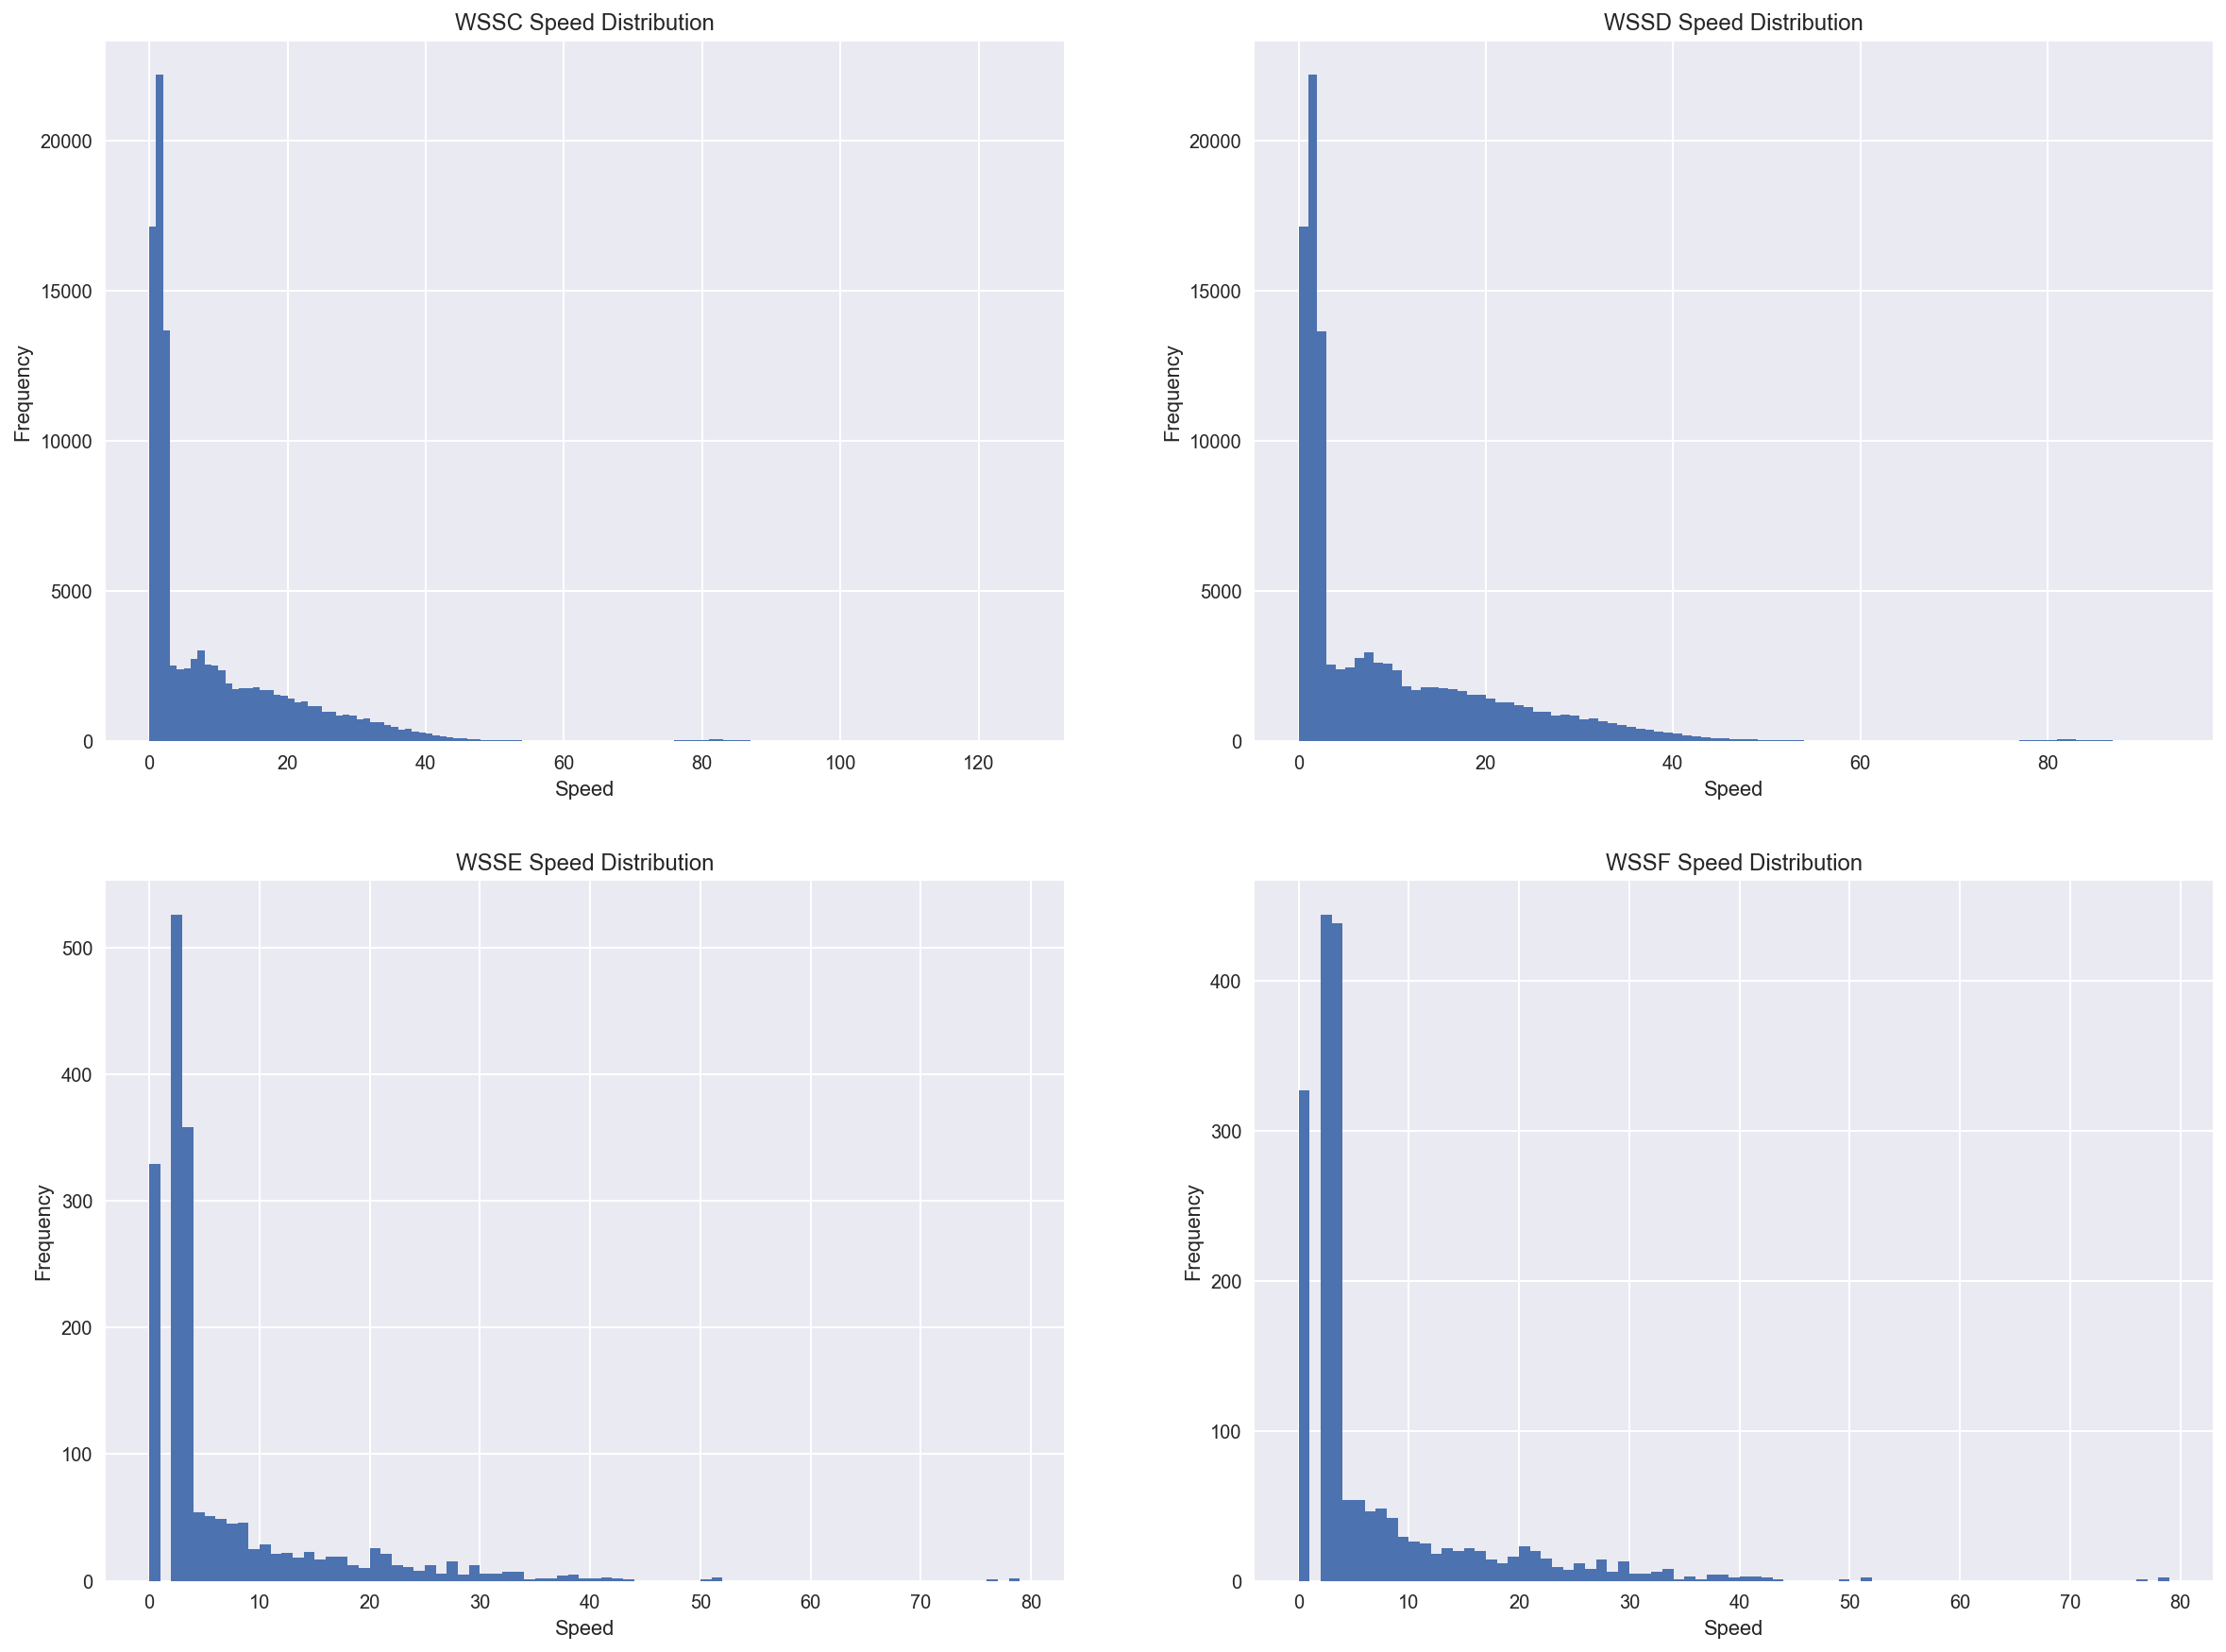

In [11]:
plt.figure(figsize=(20, 15));
plt.subplot(2,2,1)
plt.hist(df1.speed, bins=np.arange(df1.speed.min(), df1.speed.max()+1))
plt.ylabel('Frequency')
plt.xlabel('Speed')
plt.title('WSSC Speed Distribution')
plt.subplot(2,2,2)
plt.hist(df2.speed, bins=np.arange(df2.speed.min(), df2.speed.max()+1))
plt.ylabel('Frequency')
plt.xlabel('Speed')
plt.title('WSSD Speed Distribution')
plt.subplot(2,2,3)
plt.hist(df3.speed, bins=np.arange(df3.speed.min(), df3.speed.max()+1))
plt.ylabel('Frequency')
plt.xlabel('Speed')
plt.title('WSSE Speed Distribution')
plt.subplot(2,2,4)
plt.hist(df4.speed, bins=np.arange(df4.speed.min(), df4.speed.max()+1))
plt.ylabel('Frequency')
plt.xlabel('Speed')
plt.title('WSSF Speed Distribution')
plt.show()

### Findings
The 4 output figures above show that there is high frequency of pick-up speed of 0. It is unnormal and should be figured out in later analysis.

In [10]:
grouped = df.groupby('itapudid') # Group the dataset by itapudid
grouped.describe().head(10)

speed                                                 
                        count      mean        std  min  25%  50%    75%   max
itapudid                                                                      
163540006001DC915B4EF    60.0  7.033333  11.413591  0.0  0.0  1.0  11.25  39.0
163540011001DC924C17D  2314.0  5.668539   9.408231  0.0  0.0  1.0   8.00  85.0
163540017001DC924DAFD  5920.0  6.651520  10.621807  0.0  1.0  2.0   9.00  92.0
163540020001DC924C70B  4310.0  5.664733  10.912685  0.0  0.0  1.0   6.00  88.0
163540022001DC915C968  3812.0  5.927597  10.643430  0.0  0.0  1.0   8.00  88.0
163540023001DC924C17A  2604.0  5.540323   9.839526  0.0  0.0  1.0   6.00  85.0
163540024001DC915C992  4284.0  5.992764  11.335159  0.0  0.0  1.0   8.00  85.0
163540031001DC924C7B3  1192.0  5.561242   9.718175  0.0  0.0  1.0   8.00  87.0
163540032001DC9248262  3716.0  6.279333   8.763224  0.0  2.0  3.0   7.00  79.0
163540034001DC924DB03  1884.0  5.533970   9.681075  0.0  0.0  1.0   8.00  82.0

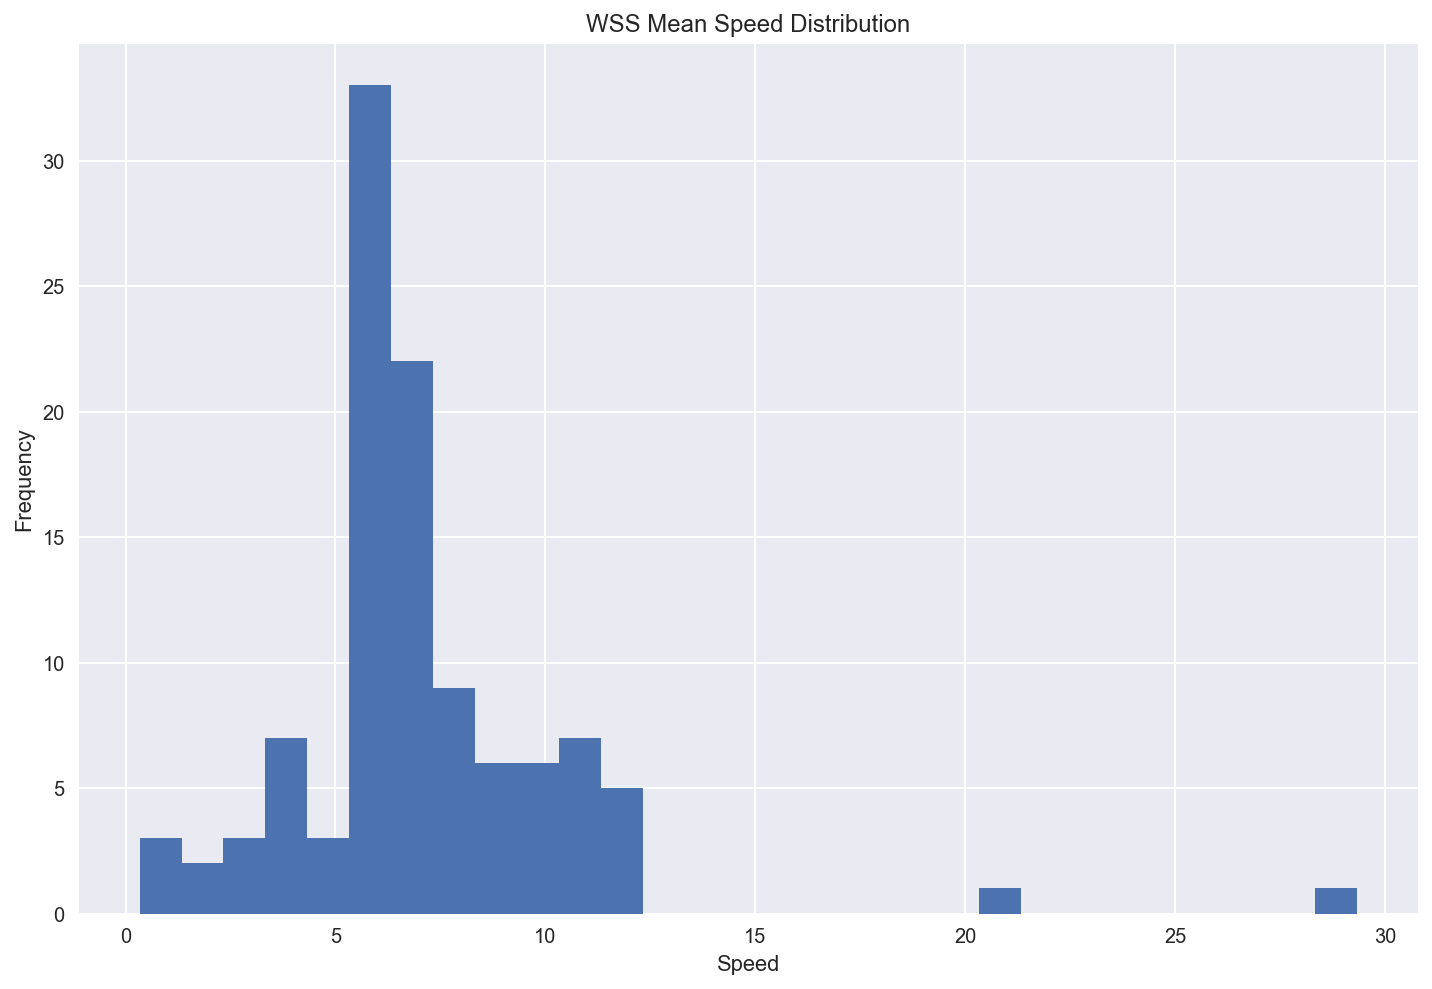

In [11]:
df_mean = df.groupby('itapudid').describe().reset_index()
df_mean = df_mean.speed
df_mean = df_mean.rename(columns = {'mean': 'speed'})
plt.hist(df_mean.speed, bins=np.arange(df_mean.speed.min(), df_mean.speed.max()+1))
plt.title('WSS Mean Speed Distribution')
plt.ylabel('Frequency')
plt.xlabel('Speed')
plt.show()
  

The figure above shows that the average pickup speed follow a Gaussian distribution.

### Trailer Level

In [4]:
df = pd.read_pickle('../data/wss_all')
df = df[df['ebs_mfg'] == 'Knorr Bremse'].reset_index(drop = True)

In [13]:
df.describe()

,mean,max,std,kurt,skew,dif_mean,dif_max,dif_std,NA_ratio,NA_ratio_dif
count,108.000000,108.000000,108.000000,107.000000,107.000000,108.000000,108.000000,107.000000,108.000000,108.0
mean,7.078026,64.472222,10.638823,8.567837,2.454967,-0.000551,12.037037,1.094407,0.014449,0.0
std,3.557229,26.847948,4.393556,7.006405,0.917739,0.306085,21.520226,1.960039,0.059183,0.0
min,0.333333,1.000000,0.000000,-1.875000,0.726340,-2.529412,0.000000,0.000000,0.000000,0.0
25%,5.667588,38.000000,9.315925,2.524001,1.622423,-0.029530,1.000000,0.474257,0.000000,0.0
50%,6.436740,80.000000,10.749551,6.402905,2.428351,0.000000,2.000000,0.581629,0.003910,0.0
75%,8.255752,85.000000,11.811459,14.183084,3.253572,0.029825,15.250000,0.984825,0.008288,0.0
max,29.152913,126.000000,34.879472,26.380353,4.195894,1.714286,120.000000,17.064879,0.500000,0.0


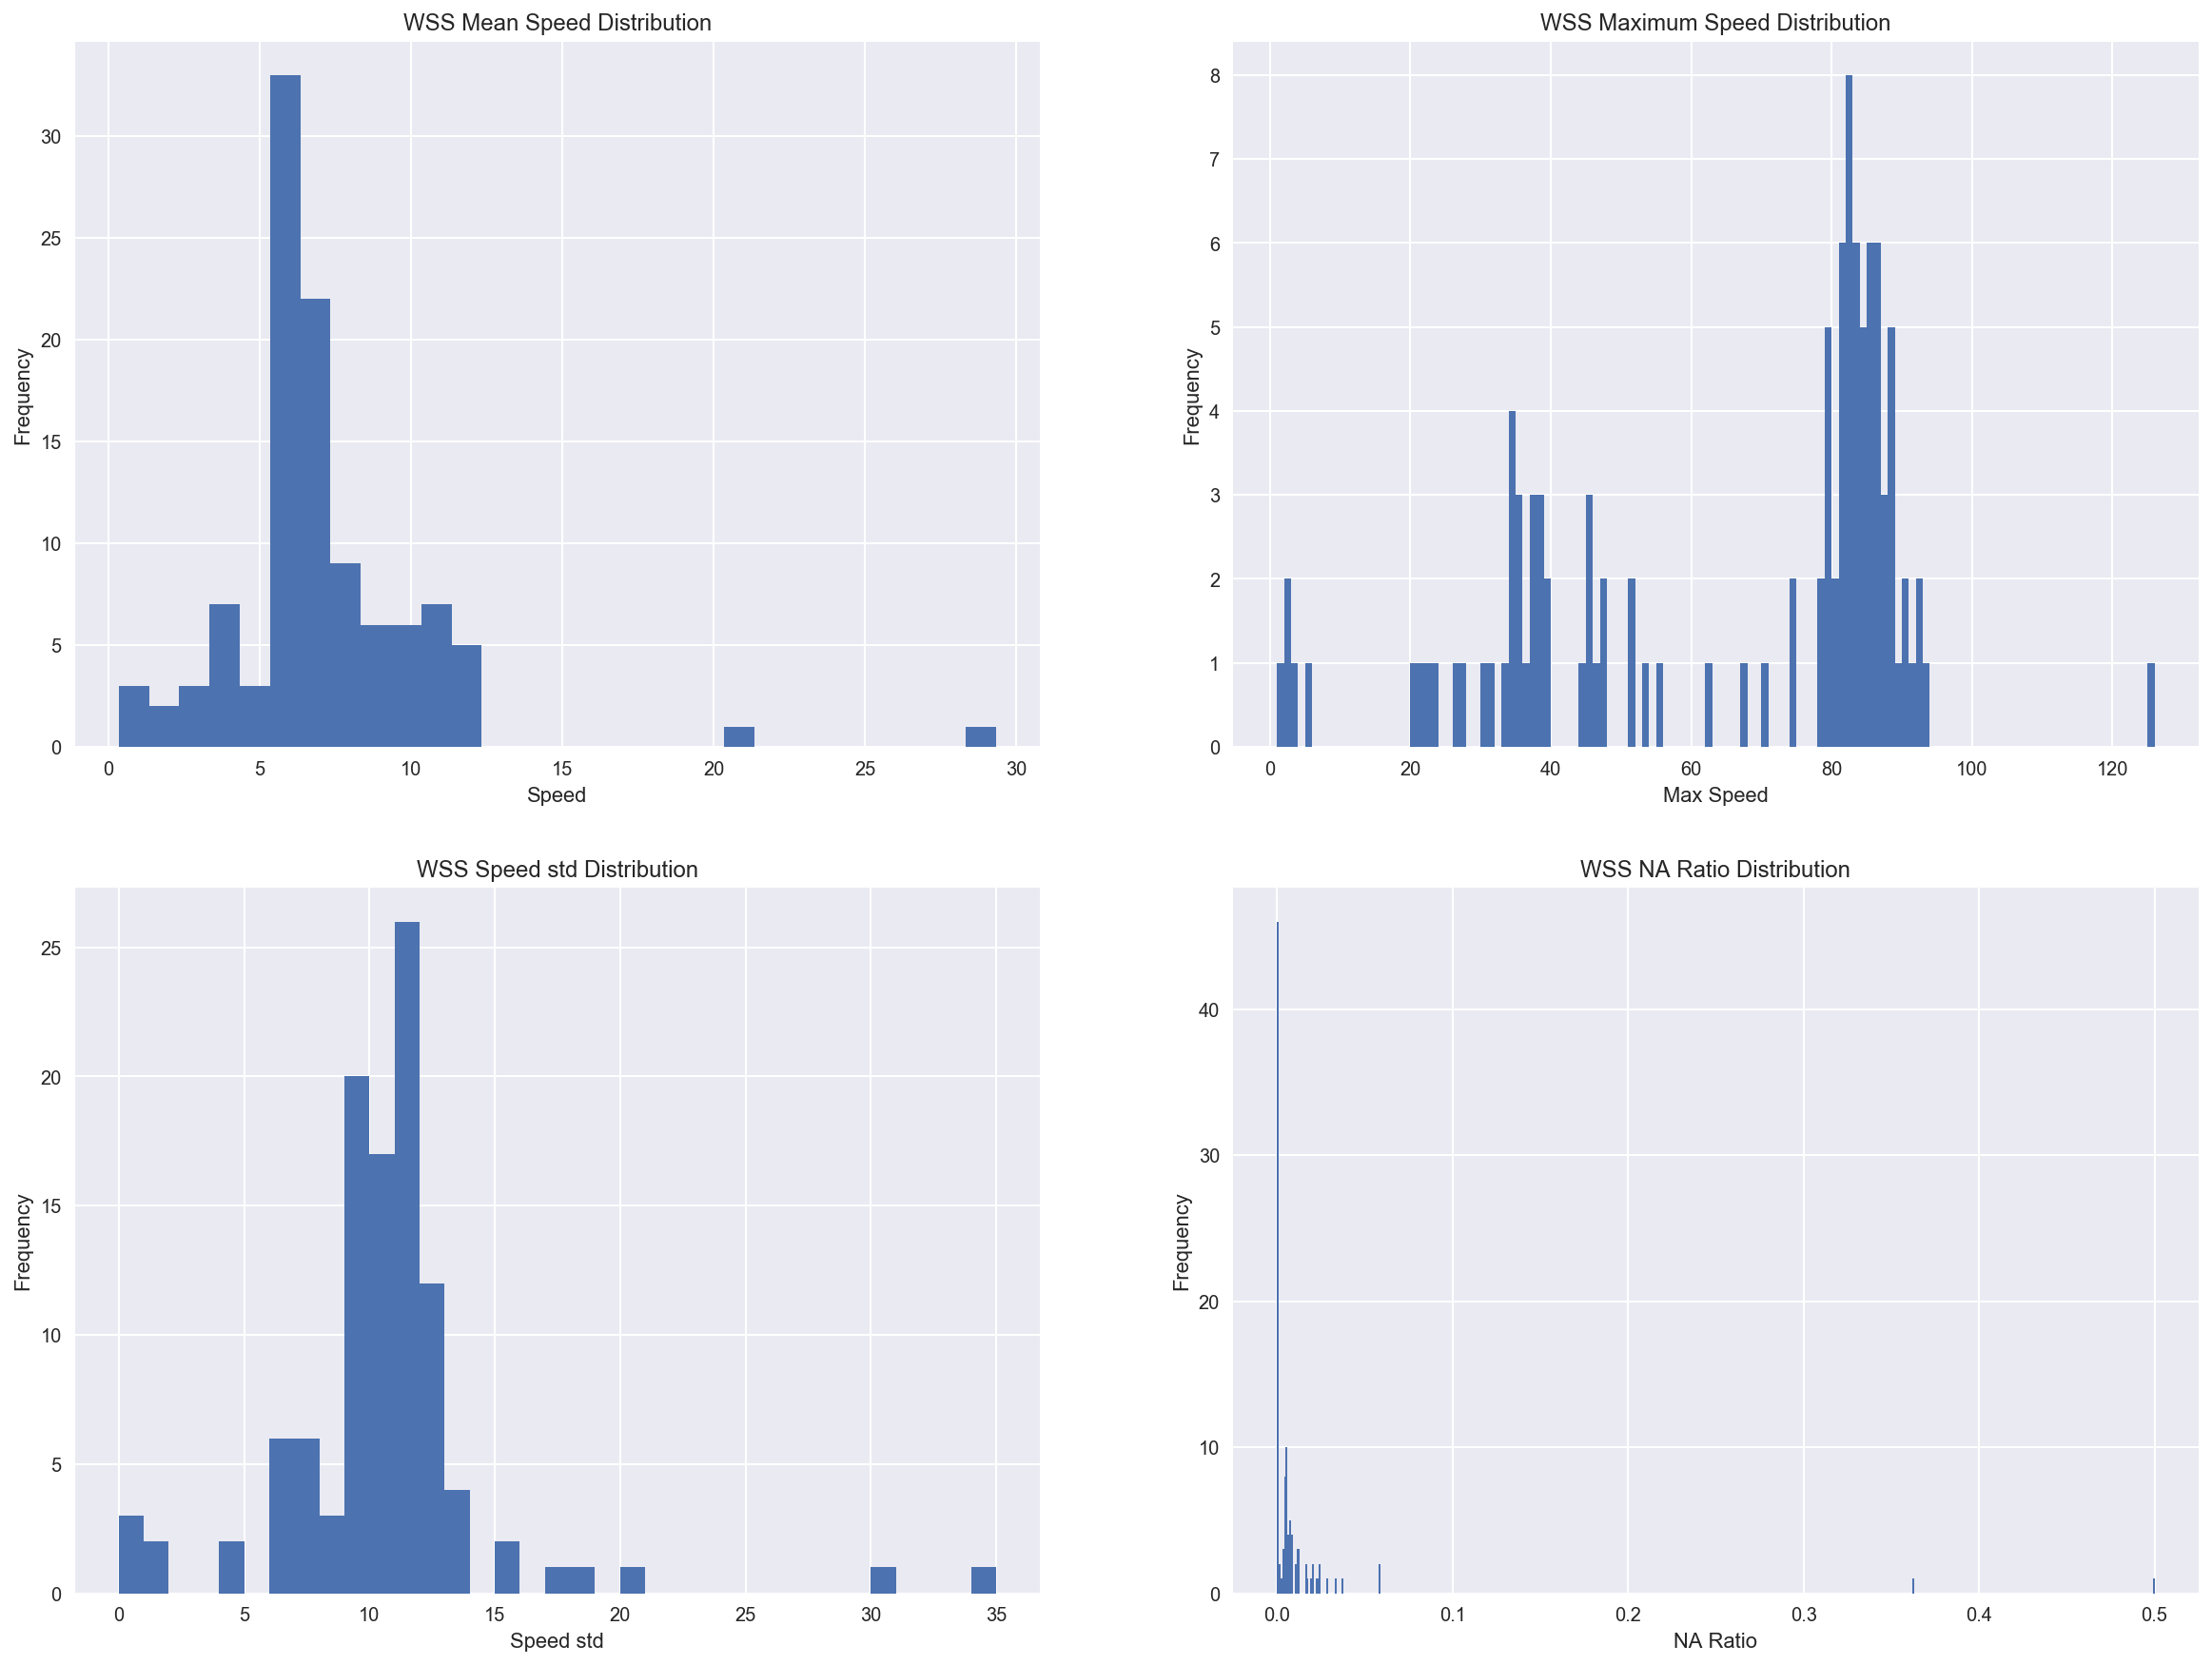

In [14]:
plt.figure(figsize=(20, 15));
plt.subplot(2,2,1)
df_mean = df[['mean']]
df_mean = df_mean.rename(columns = {'mean': 'speed'})
plt.hist(df_mean.speed, bins=np.arange(df_mean.speed.min(), df_mean.speed.max()+1))
plt.title('WSS Mean Speed Distribution')
plt.ylabel('Frequency')
plt.xlabel('Speed')
plt.subplot(2,2,2)
df_mean = df[['max']]
df_mean = df_mean.rename(columns = {'max': 'speed'})
plt.hist(df_mean.speed, bins=np.arange(df_mean.speed.min(), df_mean.speed.max()+1))
plt.title('WSS Maximum Speed Distribution')
plt.ylabel('Frequency')
plt.xlabel('Max Speed')
plt.subplot(2,2,3)
df_mean = df[['std']]
df_mean = df_mean.rename(columns = {'std': 'speed'})
plt.hist(df_mean.speed, bins=np.arange(df_mean.speed.min(), df_mean.speed.max()+1))
plt.title('WSS Speed std Distribution')
plt.ylabel('Frequency')
plt.xlabel('Speed std')
plt.subplot(2,2,4)
df = df.round(3)
plt.hist(df.NA_ratio, bins=np.arange(df.NA_ratio.min(), df.NA_ratio.max()+0.001, 0.001))
plt.title('WSS NA Ratio Distribution')
plt.ylabel('Frequency')
plt.xlabel('NA Ratio')
plt.show()

## Difference Analysis between Sensors per Trailer
This document analyzes the difference between sensors on the same trailer, including the difference in variance in pickup speed. Below the graphs show the p-values for the F-test

In [15]:
df = pd.read_pickle('../data/wss_n_c1')

In [16]:
# This function is used to calculate the F-test P-value of two individule samples
def Ftest_pvalue_rpy2(d1,d2):
    rd1 = (robjects.FloatVector(d1))
    rd2 = (robjects.FloatVector(d2))
    rvtest = robjects.r['var.test']
    return rvtest(rd1,rd2)[2][0]

# This function is used to calculate the F-test P-value per itapudid. Analyzing the difference between sensors per itap
def cal_Ftest_P(df):
    # Select the distinct itapudid
    df_new = df.groupby('itapudid').describe().reset_index().itapudid
    # Add new column speedFtestPvalue
    df_new = pd.DataFrame(df_new, columns=['itapudid','speedFtestPvalue'])
    # Find the itap whose records are less than 2
    df_drop = df.groupby('itapudid').count().reset_index()
    df_drop = df_drop[df_drop['speed']<4].itapudid
    # Drop these itap events which are not suitable for F-test analysis
    for i in df_drop:
        df_new = df_new[df_new.itapudid!=i]
    df_new = df_new.reset_index(drop=True)
    #Calculate the F-test P-value
    for i in range(df_new.shape[0]):
        df_temp = df[df['itapudid'] == df_new.get_value(i,'itapudid')]
        df_temp1 = df_temp[(df_temp['sensor'] == 'C')|(df_temp['sensor'] == 'E')]
        df_temp2 = df_temp[(df_temp['sensor'] == 'D')|(df_temp['sensor'] == 'F')]
        df_new.set_value(i, 'speedFtestPvalue', Ftest_pvalue_rpy2(df_temp1.speed.values,df_temp2.speed.values))
    return df_new

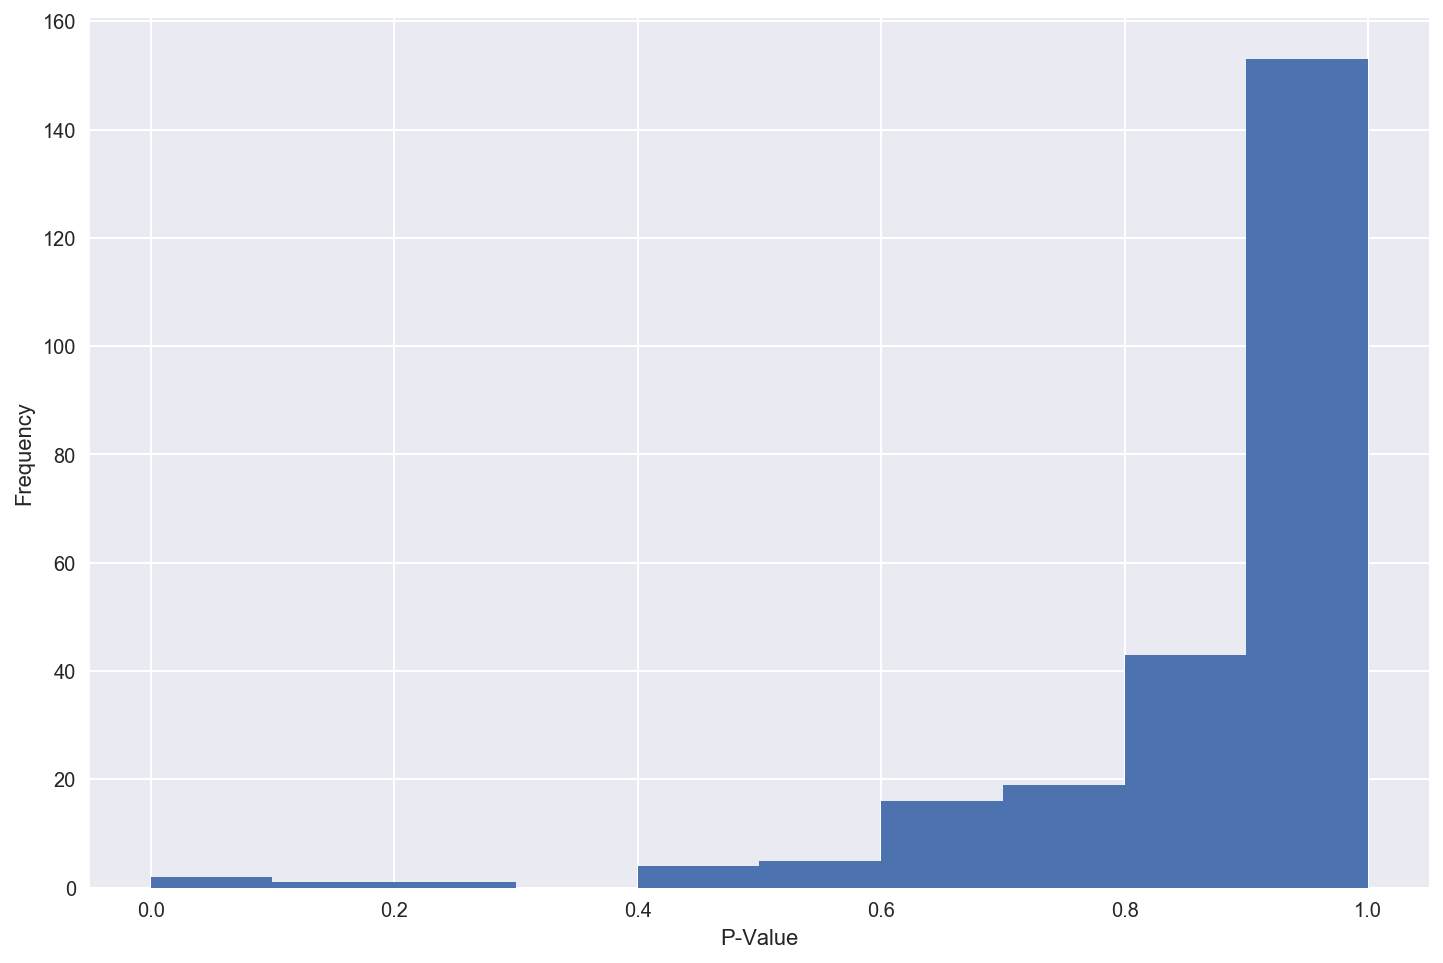

In [17]:
df_ft = cal_Ftest_P(df)
df_ft['speedFtestPvalue'].hist()
plt.ylabel('Frequency')
plt.xlabel('P-Value')
plt.show()

Conclusion: When the P value of the F test is less than 0.05, the two sensors in the same trailer are regarded as behaving differently. From the figure above we can see there is aroud 2 trailers whose sensors behave very differently, and we can suspect these trailers as outliers.

# Low dimensional Outlier Detection

## Summary
This documentation only selects two features to do the outlier detection

In [18]:
df = pd.read_pickle('../data/wss_all')
df = df.dropna(axis=0, how='any').reset_index(drop = True)
df2 = df[df['ebs_mfg'] == 'Knorr Bremse'][['mean','NA_ratio']]
X2 = df2.values

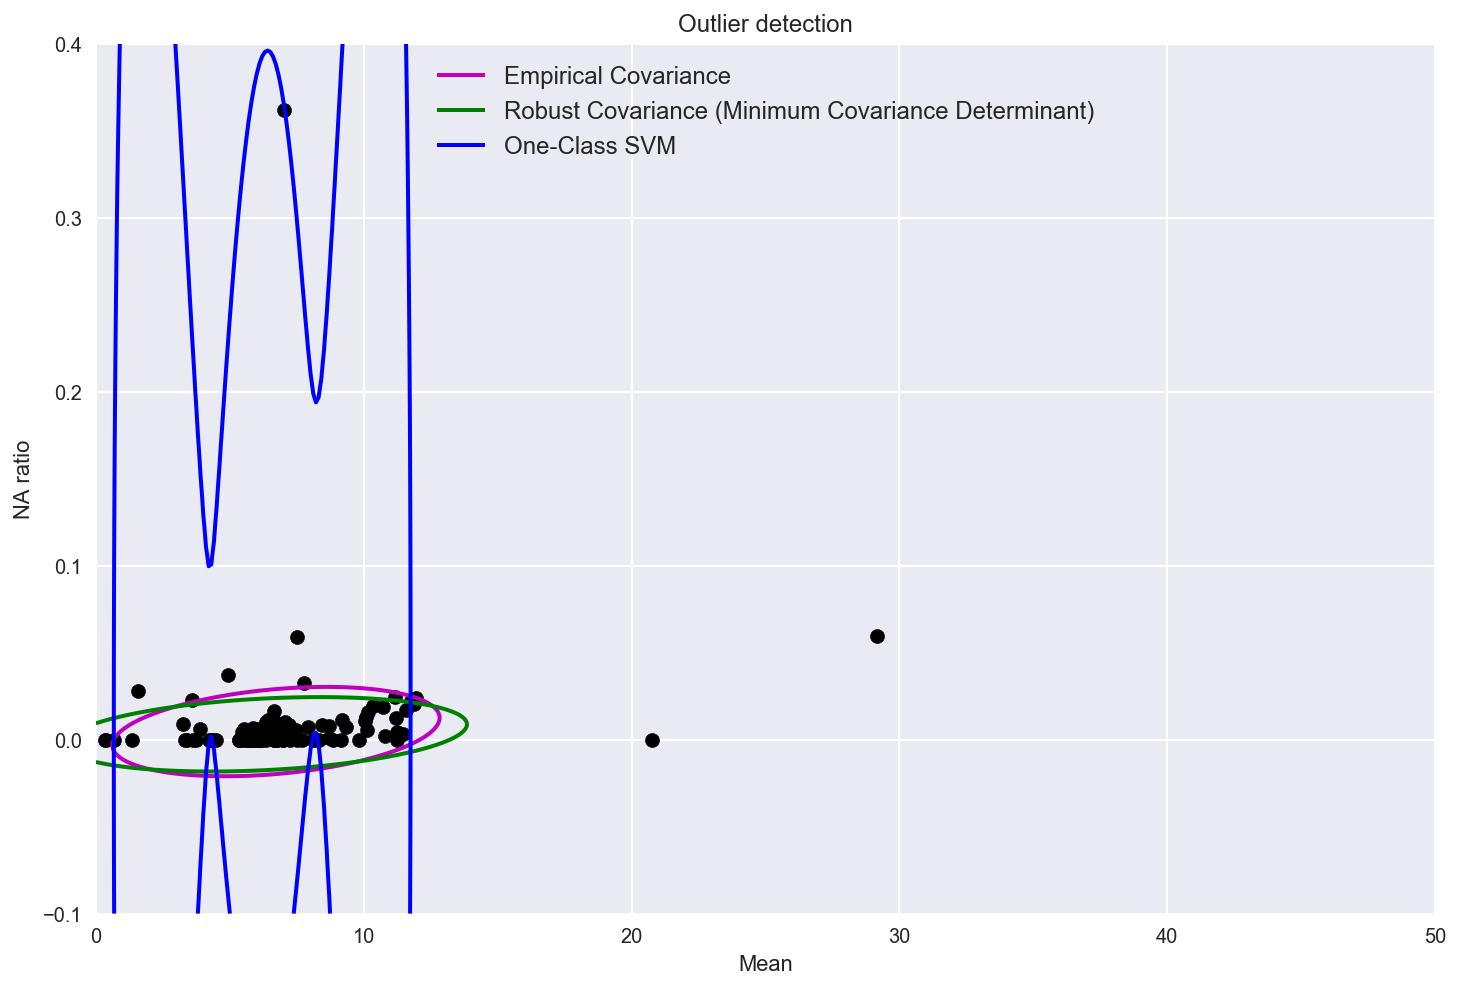

In [19]:
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=0.1),
    "Robust Covariance (Minimum Covariance Determinant)":
    EllipticEnvelope(contamination=0.1),
    "One-Class SVM": OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)}
colors = ['m', 'g', 'b']
legend1 = {}

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 50, 500), np.linspace(-0.1, 0.4, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1)
    clf.fit(X2)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

# Plot the results (= shape of the data points cloud)
plt.figure(1)  # two clusters
plt.title("Outlier detection")
plt.scatter(X2[:, 0], X2[:, 1], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("NA ratio")
plt.xlabel("Mean")
plt.show()

# Isolation Forest and Local Outlier Factor

## Summary
Since we have more than 2 features per record in our dataset, it is necessary to do some high dimentional outlier analysis by using machine learning algorithms. This documentation will give detailed decription of using two methods to do outlier detection

In [20]:
df = pd.read_pickle('../data/wss_all')
df = df[df['ebs_mfg'] == 'Knorr Bremse']
df = df.dropna(axis=0, how='any').reset_index(drop = True)
df_i = df[['mean', 'max', 'std', 'kurt', 'skew', 'dif_mean', 'dif_max',
       'dif_std', 'NA_ratio', 'NA_ratio_dif']]

In [17]:
df[df['NA_ratio']>0.3]

,itapudid,count,mean,max,std,kurt,skew,dif_mean,dif_max,dif_std,NA_ratio,NA_ratio_dif,ebs_mfg,outlier
0,163540006001DC915B4EF,60.0,7.033333,39.0,11.413591,1.297767,1.595819,0.0,1.0,0.262613,0.361702,0.0,Knorr Bremse,-1


In [4]:
df = pd.read_pickle('../data/wss_all')
df = df[df['ebs_mfg'] == 'Knorr Bremse']

In [9]:
df = df[df['count'] > 40]
df = df.dropna(axis=0, how='any').reset_index(drop = True)
df_i = df[['mean', 'max', 'std', 'kurt', 'skew', 'dif_mean', 'dif_max',
       'dif_std', 'NA_ratio', 'NA_ratio_dif']]

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(df_i.values)
clf = LocalOutlierFactor(n_neighbors=35, contamination = 0.1)
y_pred = clf.fit_predict(rescaledX)
df1 = df
df1['outlier'] = y_pred

In [11]:
df1[df1['outlier'] == -1]

,itapudid,count,mean,max,std,kurt,skew,dif_mean,dif_max,dif_std,NA_ratio,NA_ratio_dif,ebs_mfg,outlier
0,163540006001DC915B4EF,60.0,7.033333,39.0,11.413591,1.297767,1.595819,0.000000,1.0,0.262613,0.361702,0.0,Knorr Bremse,-1
34,164940043001DC92C87F4,242.0,5.338843,79.0,9.704817,26.380353,4.195894,0.033058,6.0,0.825973,0.000000,0.0,Knorr Bremse,-1
41,164950006001DC92C4708,70.0,20.771429,92.0,30.523059,0.643268,1.494435,1.714286,92.0,17.064879,0.000000,0.0,Knorr Bremse,-1
46,164950035001DC92C46F6,412.0,29.152913,84.0,34.879472,-1.338755,0.726340,-0.024272,3.0,0.498185,0.059361,0.0,Knorr Bremse,-1
51,164950046001DC92C5AD3,1662.0,7.903129,126.0,13.382202,14.911773,3.340144,0.131167,120.0,4.384626,0.007168,0.0,Knorr Bremse,-1
60,170510090001DC92483A3,8770.0,11.955530,93.0,10.836812,2.633926,1.233259,0.044698,76.0,2.503795,0.024037,0.0,Knorr Bremse,-1
61,170510091001DC924DABE,8894.0,10.726445,83.0,12.229851,4.710261,1.784717,0.279964,76.0,4.272448,0.018756,0.0,Knorr Bremse,-1
73,170540057001DC924818A,7268.0,10.784810,81.0,11.879223,2.103637,1.330603,0.073198,73.0,1.889788,0.002197,0.0,Knorr Bremse,-1
79,170540066001DC924D740,2948.0,10.130936,81.0,11.791703,5.248671,1.837759,0.073270,78.0,2.381486,0.005398,0.0,Knorr Bremse,-1
85,170730054001DC92C849A,70.0,1.571429,23.0,4.909534,12.862996,3.703729,0.057143,1.0,0.235504,0.027778,0.0,Knorr Bremse,-1


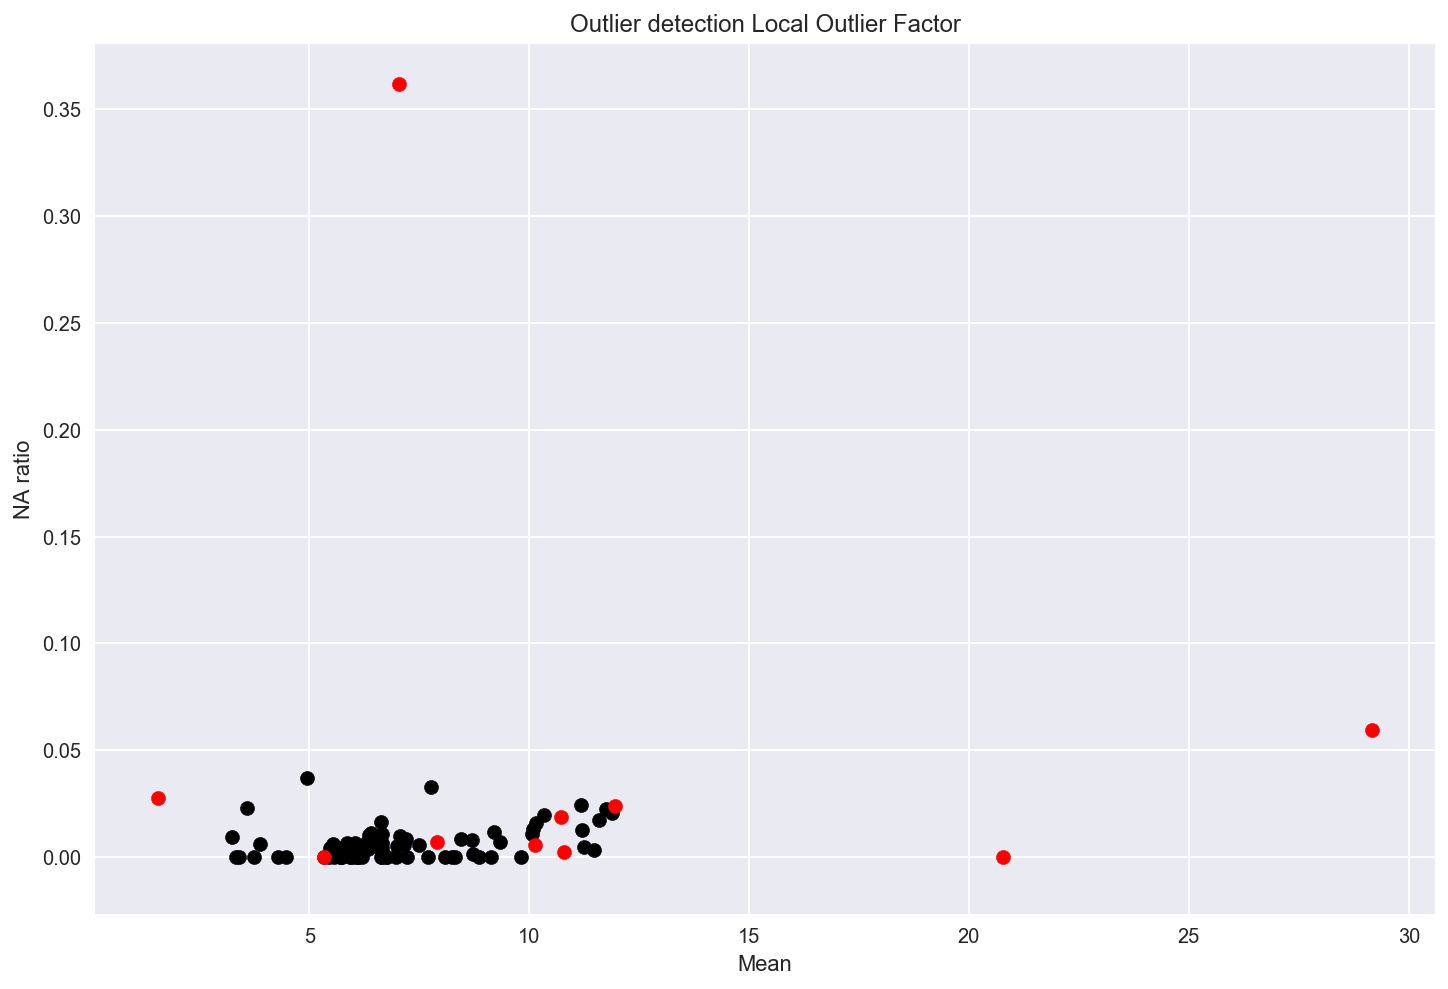

In [12]:
df1_1 = df1[df1['outlier'] == 1][['mean','NA_ratio']]
X1 = df1_1.values
df1_2 = df1[df1['outlier'] == -1][['mean','NA_ratio']]
X2 = df1_2.values
plt.figure(1) 
plt.title("Outlier detection Local Outlier Factor")
plt.scatter(X1[:, 0], X1[:, 1], color='black')
plt.scatter(X2[:, 0], X2[:, 1], color='red')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.ylabel("NA ratio")
plt.xlabel("Mean")
plt.show()

In [13]:
clf2 = IsolationForest(contamination=0.1, max_features = 10)
clf2.fit(df_i.values)
y_pred2 = clf2.predict(df_i.values)
df1 = df
df1['outlier'] = y_pred2


In [14]:
df1[df1['outlier'] == -1]

,itapudid,count,mean,max,std,kurt,skew,dif_mean,dif_max,dif_std,NA_ratio,NA_ratio_dif,ebs_mfg,outlier
0,163540006001DC915B4EF,60.0,7.033333,39.0,11.413591,1.297767,1.595819,0.000000,1.0,0.262613,0.361702,0.0,Knorr Bremse,-1
16,163910056001DC92C9436,218.0,3.247706,34.0,6.710822,8.641689,2.968859,-0.146789,1.0,1.762919,0.009091,0.0,Knorr Bremse,-1
34,164940043001DC92C87F4,242.0,5.338843,79.0,9.704817,26.380353,4.195894,0.033058,6.0,0.825973,0.000000,0.0,Knorr Bremse,-1
41,164950006001DC92C4708,70.0,20.771429,92.0,30.523059,0.643268,1.494435,1.714286,92.0,17.064879,0.000000,0.0,Knorr Bremse,-1
46,164950035001DC92C46F6,412.0,29.152913,84.0,34.879472,-1.338755,0.726340,-0.024272,3.0,0.498185,0.059361,0.0,Knorr Bremse,-1
51,164950046001DC92C5AD3,1662.0,7.903129,126.0,13.382202,14.911773,3.340144,0.131167,120.0,4.384626,0.007168,0.0,Knorr Bremse,-1
60,170510090001DC92483A3,8770.0,11.955530,93.0,10.836812,2.633926,1.233259,0.044698,76.0,2.503795,0.024037,0.0,Knorr Bremse,-1
61,170510091001DC924DABE,8894.0,10.726445,83.0,12.229851,4.710261,1.784717,0.279964,76.0,4.272448,0.018756,0.0,Knorr Bremse,-1
85,170730054001DC92C849A,70.0,1.571429,23.0,4.909534,12.862996,3.703729,0.057143,1.0,0.235504,0.027778,0.0,Knorr Bremse,-1
88,170730063001DC92C4741,52.0,4.942308,20.0,4.721305,1.881331,1.317562,-0.115385,2.0,0.816182,0.037037,0.0,Knorr Bremse,-1


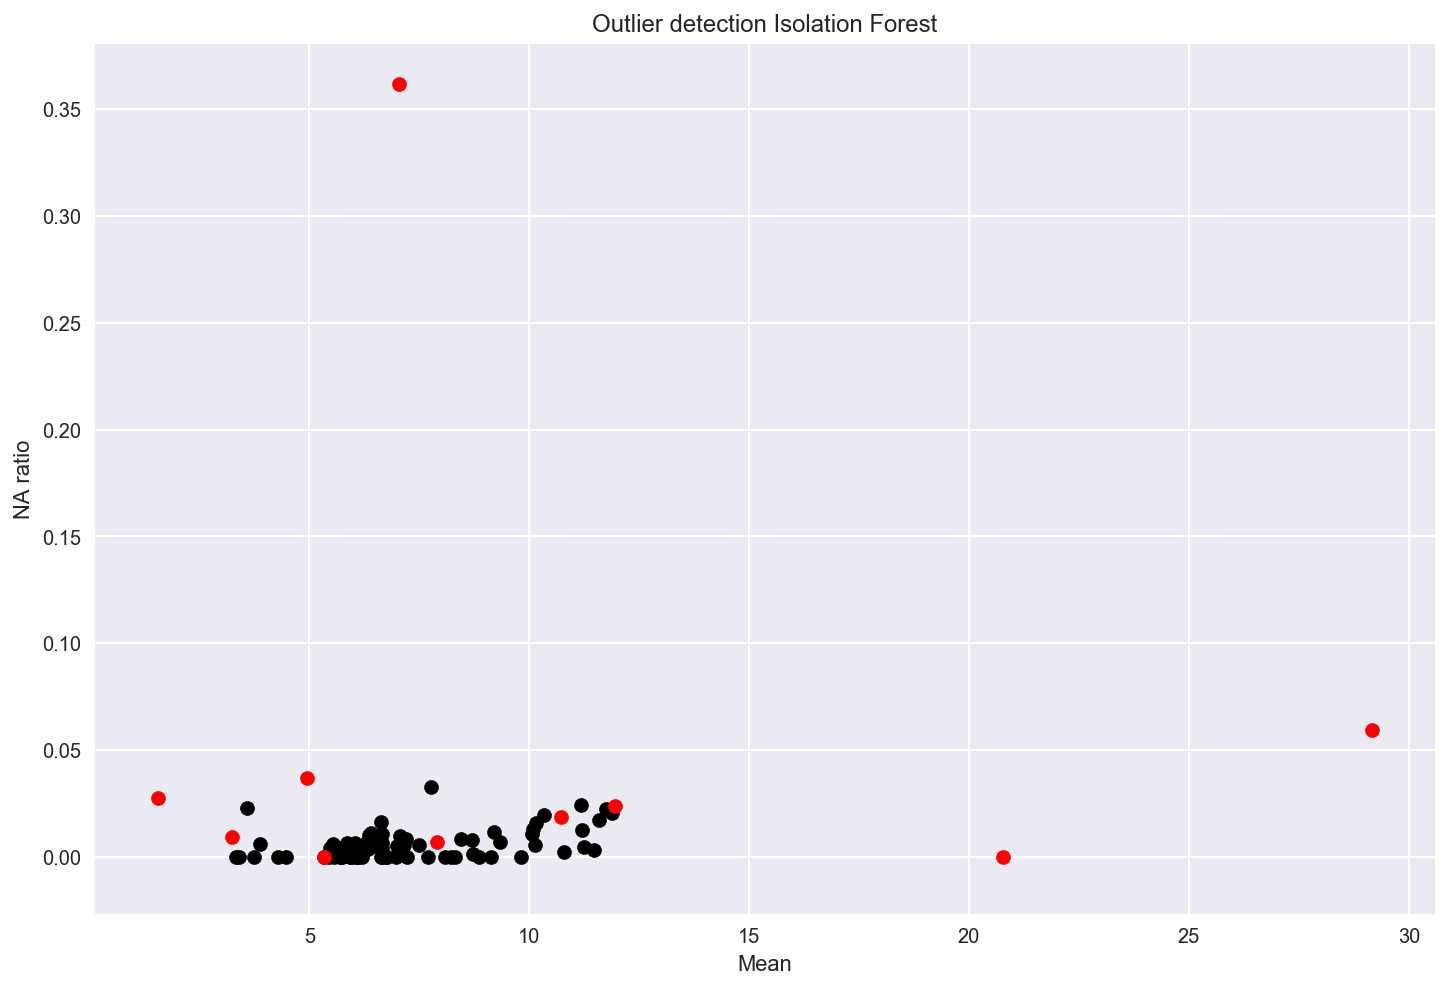

In [15]:
df1_1 = df1[df1['outlier'] == 1][['mean','NA_ratio']]
X1 = df1_1.values
df1_2 = df1[df1['outlier'] == -1][['mean','NA_ratio']]
X2 = df1_2.values
plt.figure(1) 
plt.title("Outlier detection Isolation Forest")
plt.scatter(X1[:, 0], X1[:, 1], color='black')
plt.scatter(X2[:, 0], X2[:, 1], color='red')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.ylabel("NA ratio")
plt.xlabel("Mean")
plt.show()

## Time Series Overview per Week
This documentation will give plot of how the average pick up speed per day fluctuating over time

In [27]:
df = pd.read_pickle('../data/wss_n1')

In [28]:
#Select the itapudid which have more than 3000 records, which are more representative to be analyzed
result = df.groupby('itapudid').count().reset_index()
itapudid = result[result.max1stdetectwssc>3000].itapudid

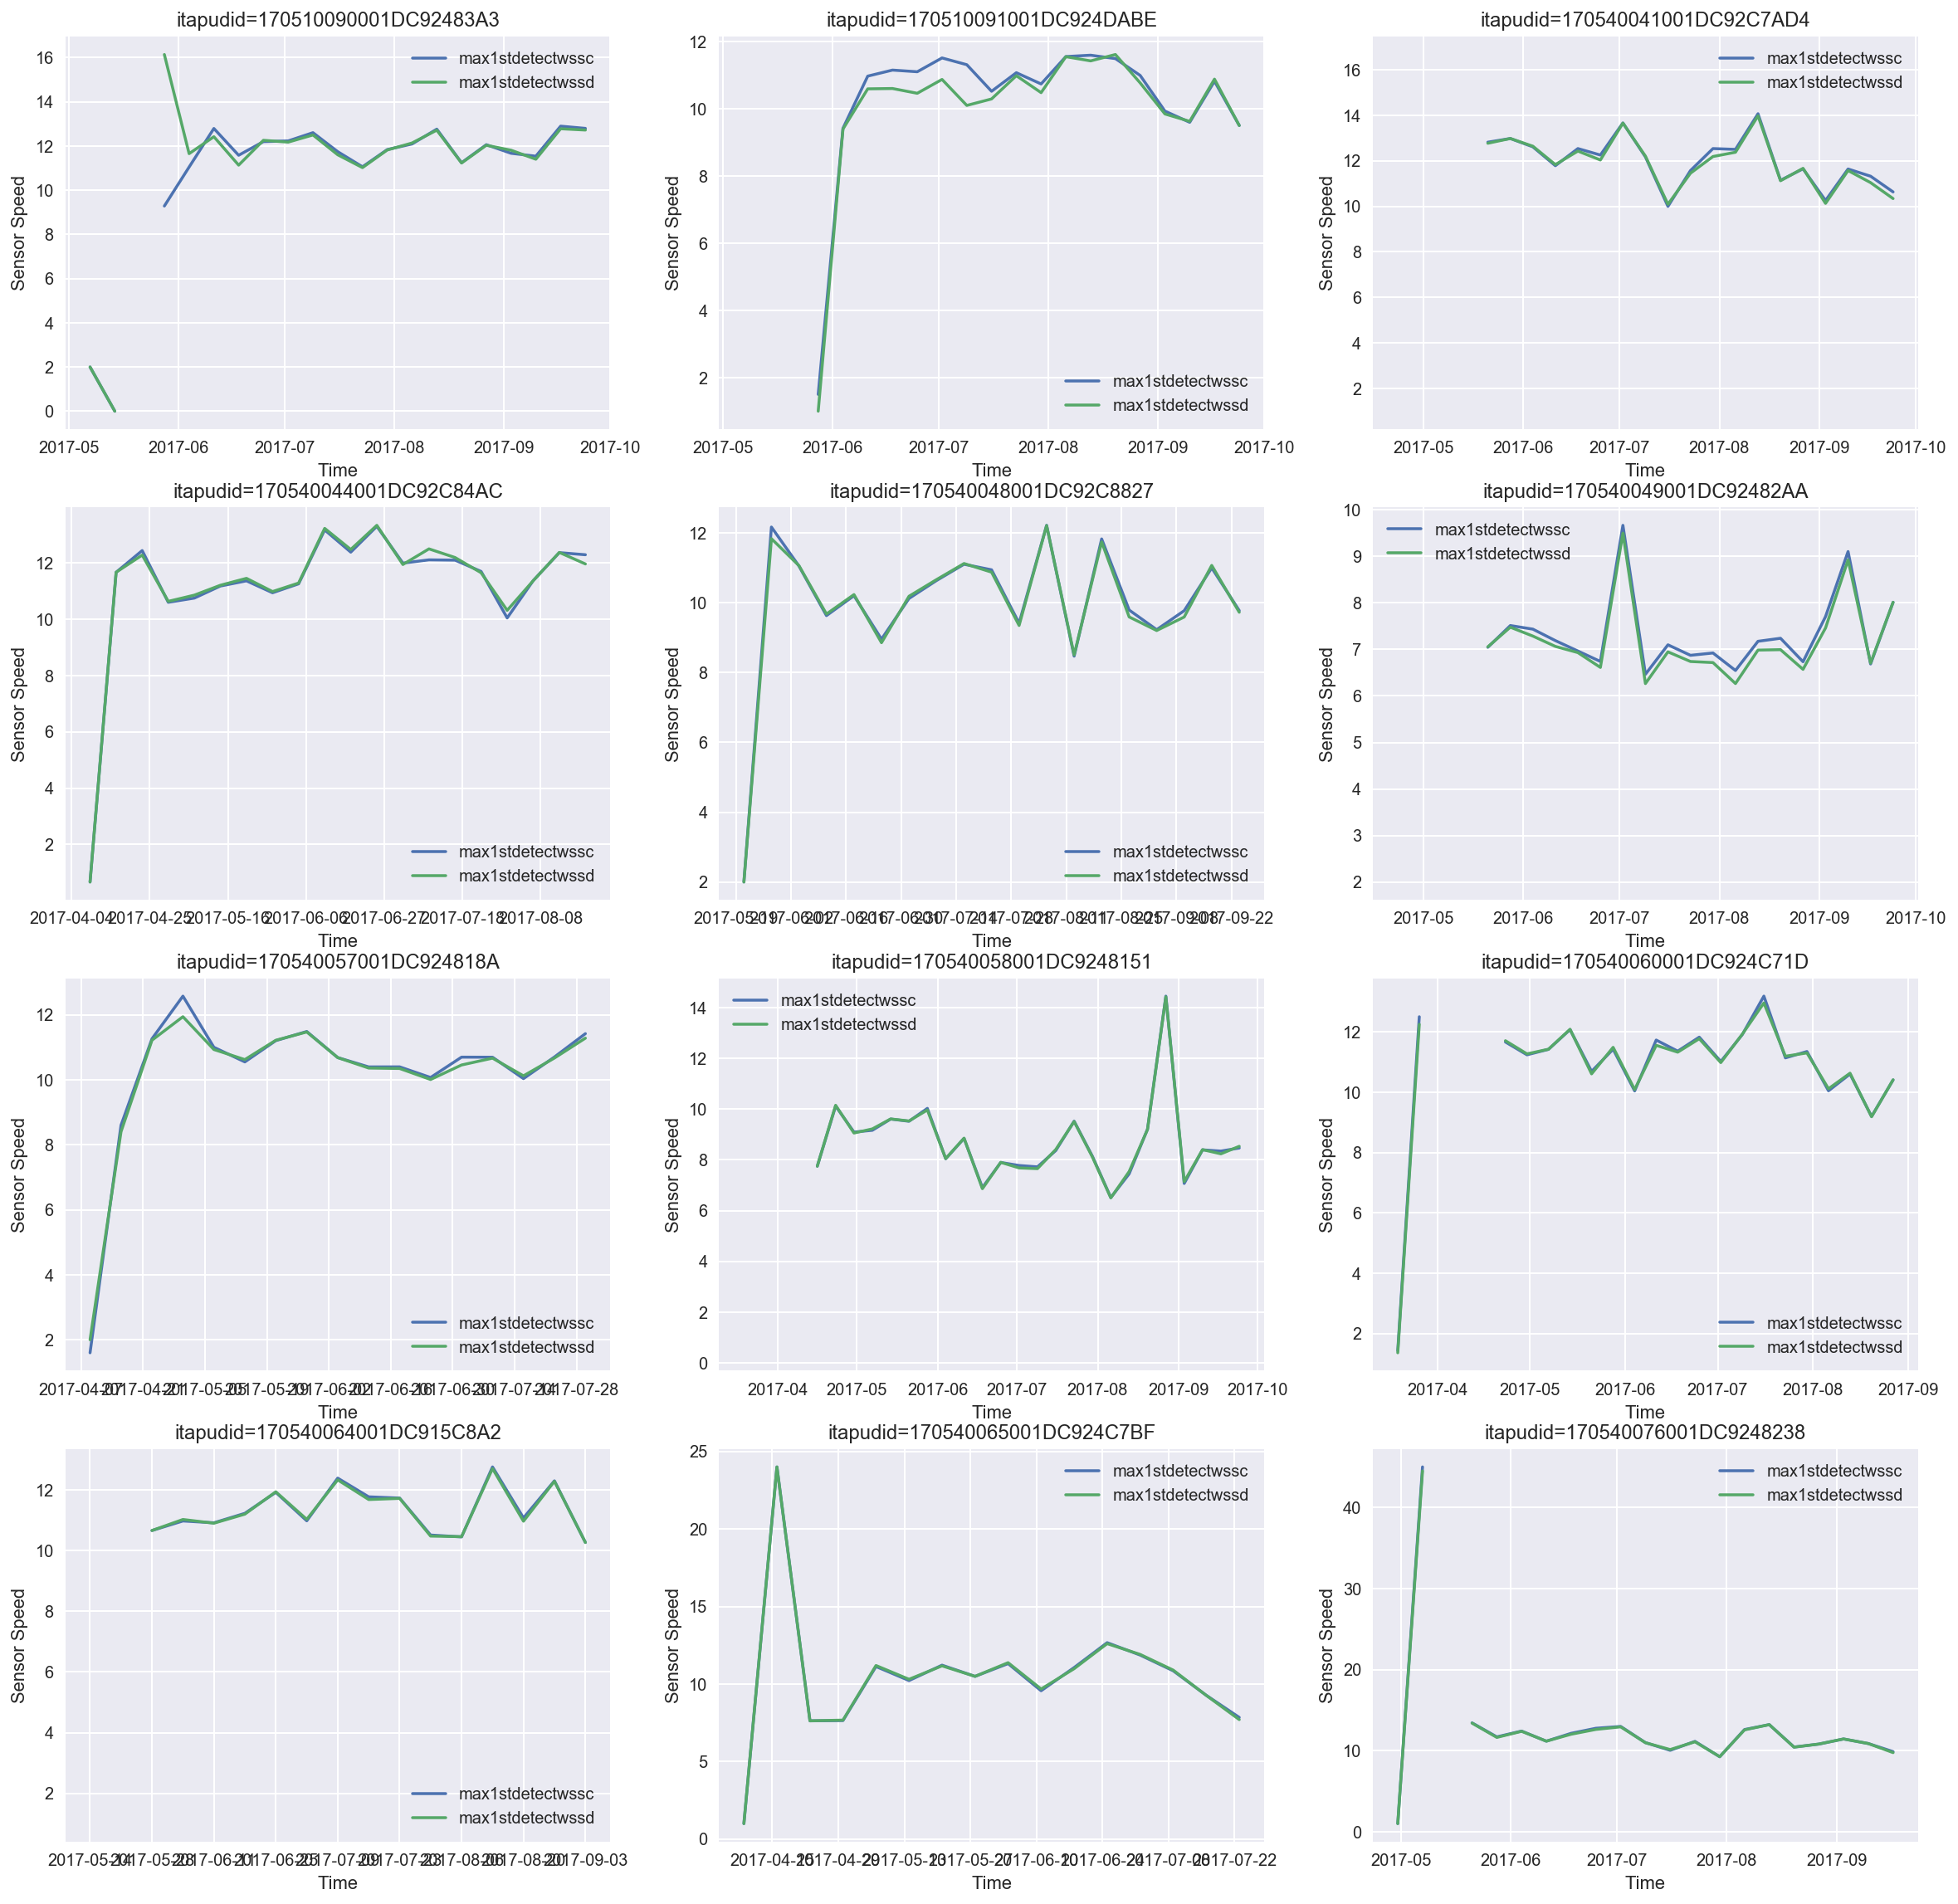

In [29]:
num = 1
plt.figure(figsize=(20, 20));
for i in itapudid:
    df1 = df[df['itapudid'] == i]
    #Sort by event time and drop NA values
    df1 = df1.sort_values(['eventtime']).dropna(axis=0, how='any').reset_index(drop = True)
    df1 = df1[df1['eventtime']!='1970-01-01'].reset_index(drop = True)
    df1 = df1.set_index(pd.DatetimeIndex(df1['eventtime']))
    #resample the data and calculate the mean value per week
    df1 = df1.resample("W").mean()
    df1 = df1[['max1stdetectwssc', 'max1stdetectwssd']]
    plt.subplot(4,3,num)
    plt.plot(df1.index.values, df1['max1stdetectwssc'], label='max1stdetectwssc')
    plt.plot(df1.index.values, df1['max1stdetectwssd'], label='max1stdetectwssd')
    plt.legend()
    plt.ylabel('Sensor Speed')
    plt.xlabel('Time')
    plt.title('itapudid=%s' % (i))
    num += 1
plt.show()

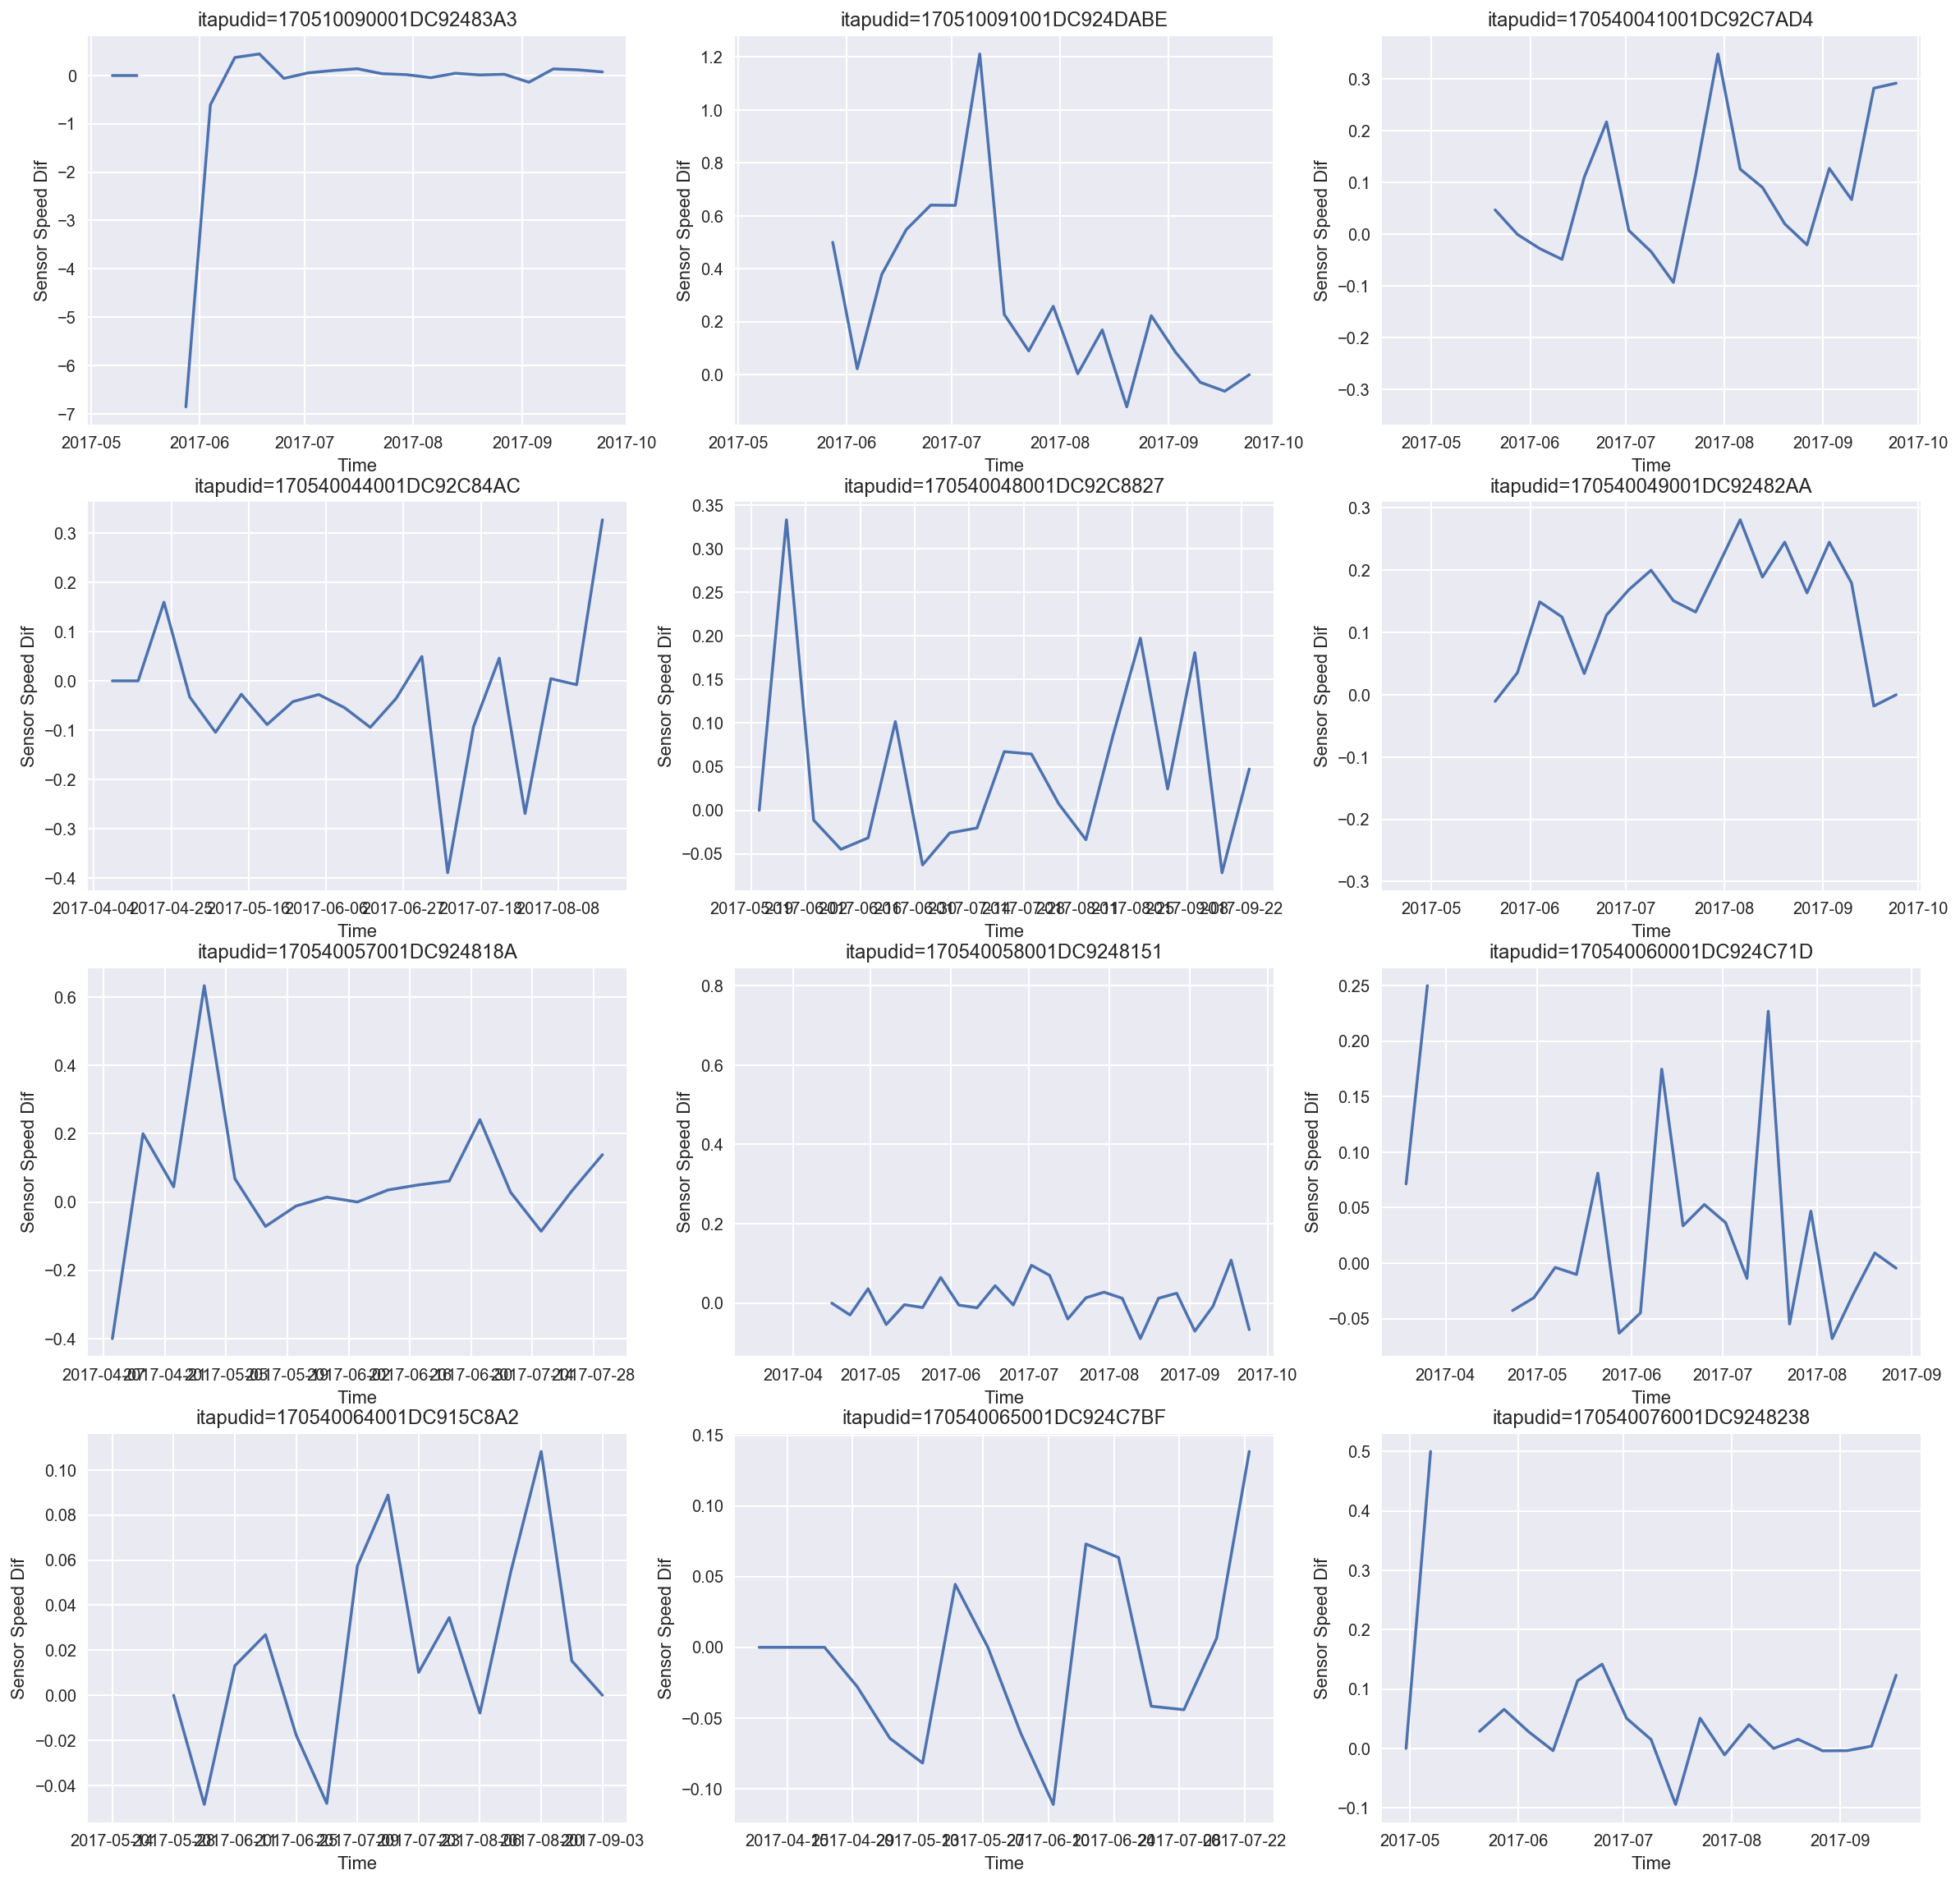

In [30]:
num = 1
plt.figure(figsize=(20, 20));
for i in itapudid:
    df1 = df[df['itapudid'] == i]
    df1 = df1.sort_values(['eventtime']).dropna(axis=0, how='any').reset_index(drop = True)
    df1 = df1[df1['eventtime']!='1970-01-01'].reset_index(drop = True)
    df1 = df1.set_index(pd.DatetimeIndex(df1['eventtime']))
    df1 = df1.resample("W").mean()
    df1 = df1[['max1stdetectwssc', 'max1stdetectwssd']]
    plt.subplot(4,3,num)
    #plot the speed difference between two sensors in a same trailer
    plt.plot(df1.index.values, df1['max1stdetectwssc'] - df1['max1stdetectwssd'])
    plt.ylabel('Sensor Speed Dif')
    plt.xlabel('Time')
    plt.title('itapudid=%s' % (i))
    num += 1
plt.show()

## NA Value Ratio Per Sensor Overtime Fluctuating
This document gives plotting of how NA value ratio per sensor fluctuating overtime

In [31]:
df = pd.read_pickle('../data/wss_n1')

In [32]:
# This function is used to calculate the na value each poweroffevent.
# The NA value of each poweroffevent each sensor will be 1 if that sensor shows NA value
def cal_ratio(df):
    # Calculate the sum of wss speed by each position grouped by itapudid. This results are used to determined the sensor position of the itap.
    df_sum = df.groupby('itapudid').sum().reset_index()
    # Rename the sum value for better looking
    df_sum = df_sum.rename(columns={"max1stdetectwssc": "sumc",
                                    "max1stdetectwssd": "sumd",
                                    "max1stdetectwsse": "sume",
                                    "max1stdetectwssf": "sumf"})
    df_sum = df_sum.set_index(['itapudid']) #reset the index by itapudid to get the speed of sensor by itapudid

    # Add 4 new columns sensor1, na_value1, sensor2, na_value2
    df_in = pd.DataFrame(df, columns=['itapudid', 'max1stdetectwssc',
                                      'max1stdetectwssd', 'max1stdetectwsse',
                                      'max1stdetectwssf', 'eventtime', 'sensor1',
                                      'na_value1', 'sensor2', 'na_value2'])
    df_in = df_in.reset_index(drop=True)

    # Calculate the number of na value each poweroffeevent
    for i in range(df_in.shape[0]):
        df_in.ix[i,'sensor1'] = cal_sen1(df_sum, df_in.get_value(i,'itapudid'))
        df_in.set_value(i,'na_value1', cal_na(df_in.get_value(i,'sensor1'),
                                              df_in.get_value(i,'max1stdetectwssc'),
                                              df_in.get_value(i,'max1stdetectwssd'),
                                              df_in.get_value(i,'max1stdetectwsse'),
                                              df_in.get_value(i,'max1stdetectwssf')))
        df_in.ix[i,'sensor2'] = cal_sen2(df_sum, df_in.get_value(i,'itapudid'))
        df_in.set_value(i,'na_value2', cal_na(df_in.get_value(i,'sensor2'),
                                          df_in.get_value(i,'max1stdetectwssc'),
                                          df_in.get_value(i,'max1stdetectwssd'),
                                          df_in.get_value(i,'max1stdetectwsse'),
                                          df_in.get_value(i,'max1stdetectwssf')))
    
    # Get useful features of the dataset
    df_in = df_in[['itapudid','sensor1','na_value1','sensor2','na_value2','eventtime']]    
    
    return df_in

# This function is used to determine sensor1 position in a single poweroffevent
def cal_sen1(df_sum, itapudid):    
    # This condition determine whether the sensors position are at C,D or not
    if ((df_sum.ix[itapudid, 'sumc'] > 0) | (df_sum.ix[itapudid, 'sumd'] > 0)):
        return 'C'
    elif (((df_sum.ix[itapudid, 'sumc'] == 0) | (df_sum.ix[itapudid, 'sumd'] == 0))) & (not((df_sum.ix[itapudid, 'sume'] > 0) | (df_sum.ix[itapudid, 'sumf'] > 0))):
        return 'C'
    elif ((math.isnan(df_sum.ix[itapudid, 'sumc']))&(math.isnan(df_sum.ix[itapudid, 'sumd']))&(math.isnan(df_sum.ix[itapudid, 'sume']))&(math.isnan(df_sum.ix[itapudid, 'sumf']))):
        return 'C'
    else:
        return 'E'
    
# This function is used to calculate how many times na value appears in a single poweroffevent per sensor
def cal_na(sensor, wssc, wssd, wsse, wssf):
    nc = 0
    
    # This condition determine whether the sensors position are at C,D or not
    if (sensor == 'C'):
        if math.isnan(wssc):
            nc += 1
    elif (sensor == 'D'):
        if math.isnan(wssd):
            nc += 1
    elif (sensor == 'E'):
        if math.isnan(wsse):
            nc += 1
    else:
        if math.isnan(wssf):
            nc += 1
    return nc

# This function is used to determine sensor2 position in a single poweroffevent
def cal_sen2(df_sum, itapudid):    
    # This condition determine whether the sensors position are at C,D or not
    if ((df_sum.ix[itapudid, 'sumc'] > 0) | (df_sum.ix[itapudid, 'sumd'] > 0)):
        return 'D'
    elif (((df_sum.ix[itapudid, 'sumc'] == 0) | (df_sum.ix[itapudid, 'sumd'] == 0))) & (not((df_sum.ix[itapudid, 'sume'] > 0) | (df_sum.ix[itapudid, 'sumf'] > 0))):
        return 'D'
    elif ((math.isnan(df_sum.ix[itapudid, 'sumc']))&(math.isnan(df_sum.ix[itapudid, 'sumd']))&(math.isnan(df_sum.ix[itapudid, 'sume']))&(math.isnan(df_sum.ix[itapudid, 'sumf']))):
        return 'D'
    else:
        return 'F'
    
# This function is used to plot the NA value ratio per week overtime
def plot_NA(result):
    result = result.sort_values(['eventtime']).reset_index(drop = True)
    result = result.set_index(pd.DatetimeIndex(result['eventtime']))
    result = result[['na_value1','na_value2']]
    result = result.resample("W").agg(['sum','count']).reset_index()
    result = pd.concat([result.eventtime, 
                        result.na_value1.rename(columns={'sum':'sum1', 'count':'count1'}),
                        result.na_value2.rename(columns={'sum':'sum2', 'count':'count2'})], axis=1)
    result = result.dropna(axis=0, how='any').reset_index(drop = True)
    result = pd.DataFrame(result, columns=['eventtime', 'sum1', 'count1', 'sum2', 'count2', 'Sensor1', 'Sensor2'])
    result.Sensor1 = result.sum1/result.count1
    result.Sensor2 = result.sum2/result.count2
    plt.ylabel('NA_Ratio')
    plt.xlabel('Time')
    plt.plot(result.eventtime, result.Sensor1, label='Sensor1')
    plt.plot(result.eventtime, result.Sensor2, label='Sensor2')
    plt.legend()

C:\Users\600002464\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
C:\Users\600002464\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


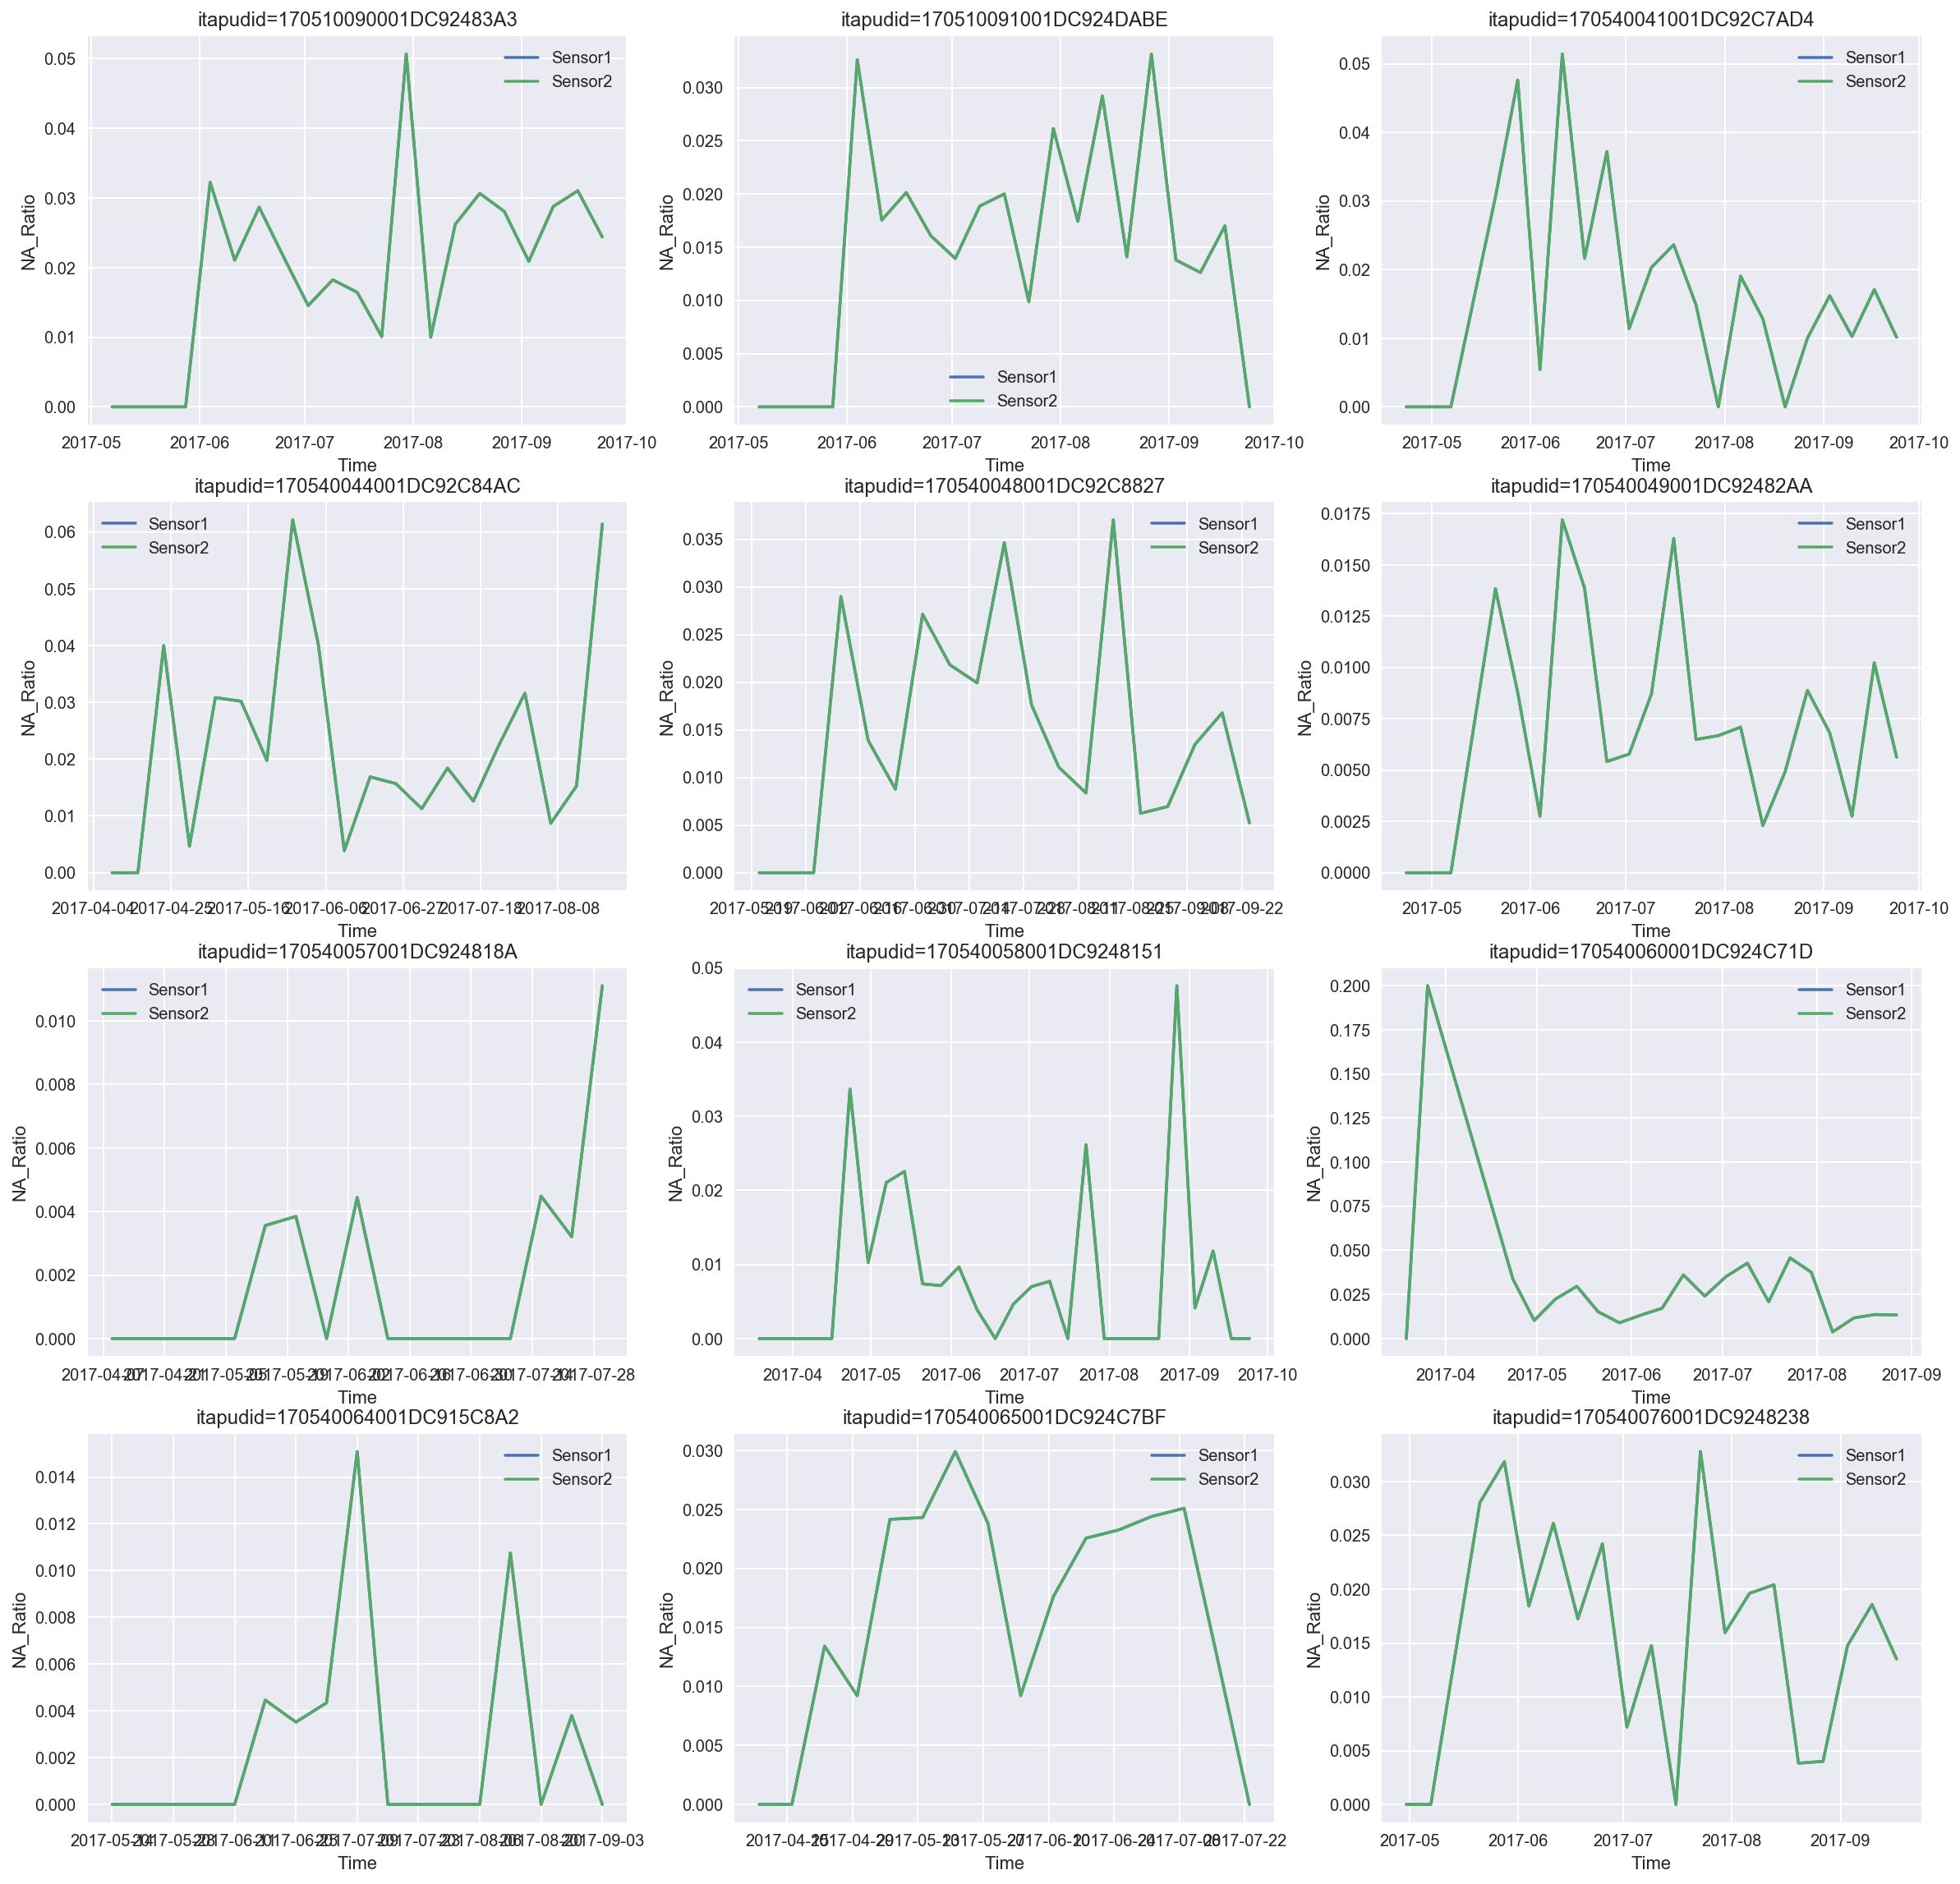

In [33]:
num = 1
plt.figure(figsize=(20, 20));
for i in itapudid:
    df1 = df[df['itapudid'] == i]
    df1 = df1[df1['eventtime']!='1970-01-01'].reset_index(drop = True)
    df_new = cal_ratio(df1)
    plt.subplot(4,3,num)
    plot_NA(df_new)
    plt.title('itapudid=%s' % (i))
    num += 1
plt.show()

## Next Steps

- Use faulty wheel speed sensor to do some speed experiments. For example, increase the air gap between sensor and wheel. Collect the faulty injection data
- Compare the faulty injection data with the data collected from normal sensors. Verify the outlier detection assumption done before